# Random Forests for seizure detection

### Reference papers

* Mursalin et al. (2017). Automated epileptic seizure detection using improved correlation-based feature selection with random forest classifier. Neurocomputing, ISSN: 0925-2312, Vol: 241, Page: 204-214. https://www3.nd.edu/~dial/publications/mursalin2017automated.pdf


* Wang, X., Gong, G., Li, N., & Qiu, S. (2019). Detection Analysis of Epileptic EEG Using a Novel Random Forest Model Combined With Grid Search Optimization. Frontiers in human neuroscience, 13, 52. https://doi.org/10.3389/fnhum.2019.00052 or https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6393755/


In [1]:
import os
import struct
import random
import keras
import math
import pandas as pd
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8) # Make the default figures a bit bigger
%matplotlib inline
np.random.seed(42)
random.seed(42)

# sklearn packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

# models
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRegressor  
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Helper Functions

In [2]:
def convert_data(file1, file2):
    df_ictal = pd.read_csv(file1,index_col=0).drop(columns=['filenames','labels'])
    df_interictal = pd.read_csv(file2, index_col=0).drop(columns=['filenames','labels'])
    num_feature = df_ictal.shape[1]
    num_ictal = df_ictal.shape[0]
    num_interictal = df_interictal.shape[0]
    #print(num_feature, num_ictal, num_interictal)
    n = num_ictal + num_interictal

    np_ictal = np.array(df_ictal)
    np_interictal = np.array(df_interictal)
    train_data = np.concatenate((np_ictal, np_interictal), axis=0)
    print("Train data shape: ", train_data.shape)
    
    label0 = [0 for i in range(num_ictal)]
    label1 = [1 for i in range(num_interictal)]
    np_label0 = np.array(label0)
    np_label1 = np.array(label1)
    label_data = np.concatenate((np_label0, np_label1), axis=0)
    print("Label data shape: ", label_data.shape)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_train_data = scaler.fit_transform(train_data)

    return scaled_train_data, label_data

In [3]:
# helper function to print performance metrics
def get_performance_metrics(model, test_features, test_labels):
    """
    Evaluate the trained model and give accuracy, precision, and recall score.
    @model: trained RandomForestClassifier
    @test_features: test set for prediction
    @test_labels: ground truth
    @return: accuracy score
    """
    predictions = model.predict(test_features)
    trues = list(np.hstack(test_labels))
    accuracy = 100*accuracy_score(predictions, trues)
    precision = 100*precision_score(predictions, trues)
    recall = 100*recall_score(predictions, trues)
    f1 = 100*f1_score(predictions, trues)
    
    # Compute probabilities for each class
    probabilities = model.predict_proba(test_features)[:, 1] 
    
    # Calculate roc auc
    model_roc_value = 100*roc_auc_score(test_labels, probabilities)
    
    # Compute AUC score
    fpr, tpr, thresholds = roc_curve(predictions, trues)
    auc_score = 100*auc(fpr, tpr)
    
    print('=== Performance Metrics ===')
    print('Accuracy: {:0.2f}%.'.format(accuracy))
    print('Precision: {:0.2f}%'.format(precision))
    print('Recall: {:0.2f}%'.format(recall))
    print('F1-score: {:0.2f}%'.format(f1))
    print('ROC score: {:0.2f}%'.format(model_roc_value))
    print('AUC score: {:0.2f}%'.format(auc_score))
    return accuracy, probabilities

In [4]:
# Plot confusion matrix with and without normalization
def plot_confusion(model, cm=plt.cm.Blues):
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                     cmap=cm,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)
        print('\n')
    plt.show()

In [5]:
# calculate roc curves
def plot_roc_curve(y_test, probabilities, model_name):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # keep probabilities for the positive outcome only
    lr_probs = probabilities

    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)

    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Random Forest: ROC AUC=%.3f' % (lr_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title("ROC Curve: %s" % model_name)
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [6]:
def plot_cv_roc_curve(fprs, tprs, model_name):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(10,6))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, marker='.',
                 label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', label='No skill')
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

#     plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#     plt.tight_layout()
    plt.title("ROC Curve: %s" % model_name)
    plt.show()
    return (f, ax)

def compute_roc_auc(model, index):
    y_predict = model.predict_proba(X_train[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y_train[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

### Load the data

In [7]:
# load data
os.chdir('/Users/malvernmadondo/Downloads/Emory/spring20/ml/seizure_dataset/revised_dataset_features')
cwd = os.getcwd()
print(cwd)

/Users/malvernmadondo/Downloads/Emory/spring20/ml/seizure_dataset/revised_dataset_features


In [8]:
# Subject: Dogs
dog1_ictal = 'dog1_ictal_data.csv'
dog2_ictal = 'dog2_ictal_data.csv'
dog3_ictal = 'dog3_ictal_data.csv'
dog4_ictal = 'dog4_ictal_data.csv'
dogs_234_ictal = 'dogs_234_ictal_data.csv'
all_dogs_ictal = "Revised_train_Dog_ictal_data_v1.csv"

# interictal data
dog1_interictal = 'Dog1_interictal_data.csv'
dog2_interictal = 'Dog2_interictal_data.csv'
dog3_interictal = 'Dog3_interictal_data.csv'
dog4_interictal = 'Dog4_interictal_data.csv'
dogs_234_interictal = 'Dogs_234_interictal_data.csv'
all_dogs_interictal = 'Revised_train_Dog_interictal_data_v1.csv'

In [9]:
# dog 1 data
dog1_scaled_train_data, dog1_train_label = convert_data(dog1_ictal, dog1_interictal)

# dog 2 data
dog2_scaled_train_data, dog2_train_label = convert_data(dog2_ictal, dog2_interictal)

# dog 3 data
dog3_scaled_train_data, dog3_train_label = convert_data(dog3_ictal, dog3_interictal)

# dog 4 data
dog4_scaled_train_data, dog4_train_label = convert_data(dog4_ictal, dog4_interictal)

# dog 234 data
dog234_scaled_train_data, dog234_train_label = convert_data(dogs_234_ictal, dogs_234_interictal)

# qll dogs data
scaled_train_data, train_label = convert_data(all_dogs_ictal, all_dogs_interictal)

Train data shape:  (596, 800)
Label data shape:  (596,)
Train data shape:  (1320, 800)
Label data shape:  (1320,)
Train data shape:  (5240, 800)
Label data shape:  (5240,)
Train data shape:  (3047, 800)
Label data shape:  (3047,)
Train data shape:  (9607, 800)
Label data shape:  (9607,)
Train data shape:  (10203, 800)
Label data shape:  (10203,)


In [10]:
# all dogs
# X_train, X_test, y_train, y_test = train_test_split(scaled_train_data, train_label, train_size = 0.8)
# print("X_train data shape: ", X_train.shape)
# print("y_train data shape: ", y_train.shape)
# print("X_test data shape: ", X_test.shape)
# print("y_test data shape: ", y_test.shape)

In [10]:
# dogs 234 and using 1 as test
X_train = dog234_scaled_train_data
y_train = dog234_train_label
X_test = dog1_scaled_train_data
y_test = dog1_train_label

print("X_train data shape: ", X_train.shape)
print("y_train data shape: ", y_train.shape)
print("X_test data shape: ", X_test.shape)
print("y_test data shape: ", y_test.shape)

X_train data shape:  (9607, 800)
y_train data shape:  (9607,)
X_test data shape:  (596, 800)
y_test data shape:  (596,)


In [20]:
# specific dog X hakuna 
X_train, X_test, y_train, y_test = train_test_split(dog3_scaled_train_data, dog3_train_label, train_size = 0.8)
print("X_train data shape: ", X_train.shape)
print("y_train data shape: ", y_train.shape)
print("X_test data shape: ", X_test.shape)
print("y_test data shape: ", y_test.shape)

X_train data shape:  (4192, 800)
y_train data shape:  (4192,)
X_test data shape:  (1048, 800)
y_test data shape:  (1048,)


### Load human data

In [11]:
p1_ictal = "Revised_train_Patient_1_ictal_data_v1.csv"
p1_interictal ="Revised_train_Patient_1_interictal_data_v1.csv"

p2_ictal ="Revised_train_Patient_2_ictal_data_v1.csv"
p2_interictal ="Revised_train_Patient_2_interictal_data_v1.csv"

p3_ictal ="Revised_train_Patient_3_ictal_data_v1.csv"
p3_interictal ="Revised_train_Patient_3_interictal_data_v1.csv"

p4_ictal ="Revised_train_Patient_4_ictal_data_v1.csv"
p4_interictal ="Revised_train_Patient_4_interictal_data_v1.csv"

p5_ictal = "Revised_train_Patient_5_ictal_data_v1.csv"
p5_interictal = "Revised_train_Patient_5_interictal_data_v1.csv"

p6_ictal ="Revised_train_Patient_6_ictal_data_v1.csv"
p6_interictal ="Revised_train_Patient_6_interictal_data_v1.csv"

p7_ictal = "Revised_train_Patient_7_ictal_data_v1.csv"
p7_interictal = "Revised_train_Patient_7_interictal_data_v1.csv"

p8_ictal ="Revised_train_Patient_8_ictal_data_v1.csv"
p8_interictal ="Revised_train_Patient_8_interictal_data_v1.csv"

In [12]:
# transform the data with Scaler

# patient 1 data
p1_scaled_train_data, p1_train_label = convert_data(p1_ictal, p1_interictal)

# patient 2 data
p2_scaled_train_data, p2_train_label = convert_data(p2_ictal, p2_interictal)

# patient 3 data
p3_scaled_train_data, p3_train_label = convert_data(p3_ictal, p3_interictal)

# patient 4 data
p4_scaled_train_data, p4_train_label = convert_data(p4_ictal, p4_interictal)

# patient 5 data
p5_scaled_train_data, p5_train_label = convert_data(p5_ictal, p5_interictal)

# patient 6 data
p6_scaled_train_data, p6_train_label = convert_data(p6_ictal, p6_interictal)

# patient 7 data
p7_scaled_train_data, p7_train_label = convert_data(p7_ictal, p7_interictal)

# patient 8 data
p8_scaled_train_data, p8_train_label = convert_data(p8_ictal, p8_interictal)

Train data shape:  (174, 3400)
Label data shape:  (174,)
Train data shape:  (3141, 800)
Label data shape:  (3141,)
Train data shape:  (1041, 2750)
Label data shape:  (1041,)
Train data shape:  (210, 3600)
Label data shape:  (210,)
Train data shape:  (2745, 3200)
Label data shape:  (2745,)
Train data shape:  (2997, 1500)
Label data shape:  (2997,)
Train data shape:  (3521, 1800)
Label data shape:  (3521,)
Train data shape:  (1890, 800)
Label data shape:  (1890,)


In [219]:
# specific dog X hakuna 
X_train, X_test, y_train, y_test = train_test_split(p8_scaled_train_data, p8_train_label, train_size = 0.8)
print("X_train data shape: ", X_train.shape)
print("y_train data shape: ", y_train.shape)
print("X_test data shape: ", X_test.shape)
print("y_test data shape: ", y_test.shape)

X_train data shape:  (1512, 800)
y_train data shape:  (1512,)
X_test data shape:  (378, 800)
y_test data shape:  (378,)


### Baseline Model

In [21]:
# fit the model
baseline = LogisticRegression(solver='saga')
baseline.fit(X_train, y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
# Actual class predictions
baseline_pred = baseline.predict(X_test)

# compute cv accuracies
baseline_accuracies = cross_val_score(estimator=baseline, X=X_train, y=y_train, cv=10, scoring='roc_auc')

# performance metrics
baseline_accuracy, baseline_probabilites = get_performance_metrics(baseline, X_test, y_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, baseline_pred))

print("\n=== All AUC Scores ===")
print(baseline_accuracies)

print("\n=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", baseline_accuracies.mean())

print("\n=== STD AUC Score ===")
print("STD AUC Score - Random Forest: ", baseline_accuracies.std())

=== Performance Metrics ===
Accuracy: 98.85%.
Precision: 99.89%
Recall: 98.86%
F1-score: 99.37%
ROC score: 99.95%
AUC score: 98.85%

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.89      0.93        97
           1       0.99      1.00      0.99       951

    accuracy                           0.99      1048
   macro avg       0.99      0.94      0.96      1048
weighted avg       0.99      0.99      0.99      1048


=== All AUC Scores ===
[0.99925971 0.99138569 0.99067551 0.9948888  0.99060644 0.99481973
 0.99778975 0.99806603 0.97527283 0.99109312]

=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9923857594723737

=== STD AUC Score ===
STD AUC Score - Random Forest:  0.006500181520264138


Confusion matrix, without normalization
[[ 86  11]
 [  1 950]]


Normalized confusion matrix
[[0.88659794 0.11340206]
 [0.00105152 0.99894848]]




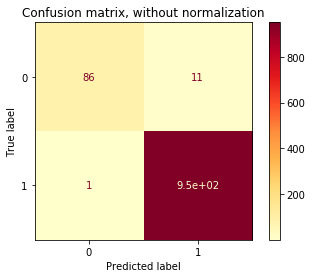

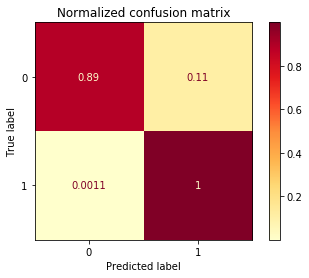

In [23]:
# Plot confusion matrices
plot_confusion(model=baseline, cm=plt.cm.YlOrRd)

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=1.000


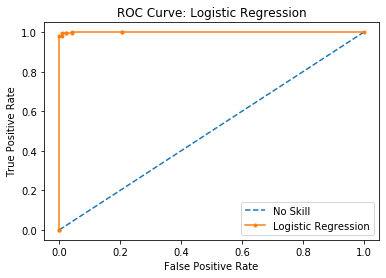

In [24]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
plot_roc_curve(y_test, probabilities=baseline_probabilites, model_name="Logistic Regression")

## Paper #1: Mursalin et al. (2017)

**Summary**

The main contribution of this paper lies on developing an automatic, efficient and scalable ICFS (*Improved Correlation-based Feature Selection*) based algorithm to detect the unpredictable occurrence of epileptic seizures in a reasonable time. In this work both time and frequency domain features are used to fed the proposed ICFS method which select the most prominent features for automatic seizure detection using a random forest classifier.

**3.1. Dataset**

The EEG database used in this study is developed by the Department of Epileptology, University of Bonn, Germany. The whole database consists of five EEG data sets (denoted as Set A -Set E). Each data set contains 100 single-channels and the duration of each channel is 23.6 s. There are 4097 data points in each channel. 

**3.2. Feature extraction**

The authors classify the features into three separate categories: 
1. time domain features;
2. frequency domain features (using Discrete wavelet transform);
3. and entropy-based features (Sample entropy (SmpE) and Shannon entropy (SE)). The SmpE value is calculated directly from EEG data while SE value is calculated from DWT coefficients (for each and every sub-band).

**3.3 Feature selection**

Authors present a new approach to feature selection, called ICFS (Improved Correlation-based Feature Selection)
that uses a correlation based heuristic to evaluate the utility of selected features. This approach seeks to improve the performance of conventional CFS method and select the minimum number of features from a large feature space.

**3.4. Classification**

* Using a Random Forest classifier as proposed by L. Breiman, *Random forests, Mach. Learn. 45 (1) (2001) 5–32*. The number of trees to be generated is 100 and the random seed is 1.

**3.5 Cross-Validation design**

* In order to reduce the bias of training and test data, this study proposes employing k-fold cross-validation technique considering k = 10.

**3.6. Performance measurements**

* sensitivity (proportion of the correctly classified ictal EEGs out of the total number of labeled ictal EEGs),
\begin{equation*}
SEN = \frac{TP}{TP + FN} * 100\%
\end{equation*}


* specificity (proportion of the correctly classified inter-ictal EEGs out of the total number of labeled inter-ictal EEGs)
\begin{equation*}
SPE = \frac{TN}{TN + FP} * 100\% 
\end{equation*}


* classification accuracy (proportion of the correctly classified EEGs out of the total number of EEGs). 
\begin{equation*}
CA = \frac{TN+TP}{TN + FN + TP+ FP} * 100\%
\end{equation*}


where, TP= True Positive, FN= False Negative, TN= True Negative,
FP= False Positive, SEN= Sensitivity, SPE= Specificity, CA= Classification Accuracy

**Results**

All the 500 channels of EEG data sets are decomposed into different sub-bands using DWT of level four with fourth-order Daubechies (db4). 


### Define the model

In [267]:
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [268]:
# perform KFold cross validation and record ROC AUC values for each fold
cv = KFold(n_splits=10, random_state=1, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores, rf_cv_scores = [], [], [], []
    
for (train, test), i in zip(cv.split(X_train, y_train.ravel()), range(10)):
    rf.fit(X_train[train], y_train[train])
    _, _, auc_score_train = compute_roc_auc(rf, train)
    fpr, tpr, auc_score = compute_roc_auc(rf, test)
    scores.append([auc_score_train, auc_score])
    rf_cv_scores.append(auc_score)
    fprs.append(fpr)
    tprs.append(tpr)

In [269]:
# Actual class predictions
rf_pred = rf.predict(X_test)

# compute cv accuracies
# train_score = cross_val_score(rf, X_train, y_train.ravel())
# print("Training score: ",train_score)
# test_score = cross_val_score(rf, X_test, y_test.ravel())
# print("Test score: ", test_score)
# print('\n')
rf_accuracies = np.array(rf_cv_scores)

# performance metrics
rf_accuracy, rf_probabilites = get_performance_metrics(rf, X_test, y_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, rf_pred))

print("\n=== All AUC Scores ===")
print(rf_accuracies)

print("\n=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rf_accuracies.mean())

print("\n=== STD AUC Score ===")
print("STD AUC Score - Random Forest: ", rf_accuracies.std())

=== Performance Metrics ===
Accuracy: 98.11%.
Precision: 100.00%
Recall: 97.90%
F1-score: 98.94%
ROC score: 99.67%
AUC score: 98.95%

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        31
           1       0.98      1.00      0.99       233

    accuracy                           0.98       264
   macro avg       0.99      0.92      0.95       264
weighted avg       0.98      0.98      0.98       264


=== All AUC Scores ===
[0.99485931 0.99734043 0.9985348  0.99669148 1.         0.996337
 1.         1.         0.99916388 0.99148148]

=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9974408369405608

=== STD AUC Score ===
STD AUC Score - Random Forest:  0.0026034951246876833


### Plot results

Confusion matrix, without normalization
[[ 26   5]
 [  0 233]]


Normalized confusion matrix
[[0.83870968 0.16129032]
 [0.         1.        ]]




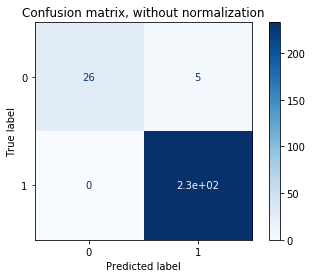

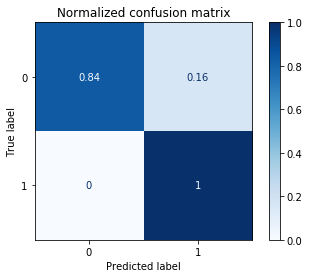

In [270]:
# Plot confusion matrices
plot_confusion(model=rf)

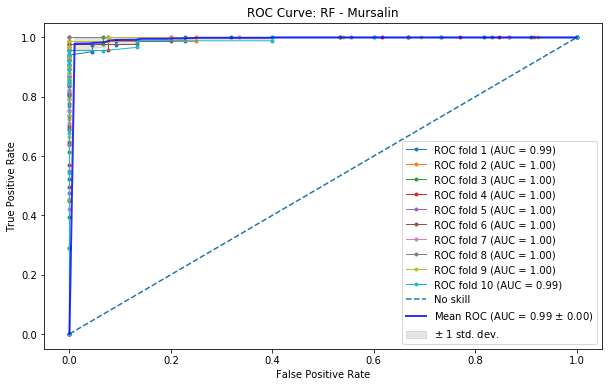

,AUC Train,AUC Test
0,1.0,0.994859
1,1.0,0.997340
2,1.0,0.998535
3,1.0,0.996691
4,1.0,1.000000
5,1.0,0.996337
6,1.0,1.000000
7,1.0,1.000000
8,1.0,0.999164
9,1.0,0.991481


In [271]:
plot_cv_roc_curve(fprs, tprs, model_name="RF - Mursalin");
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.997


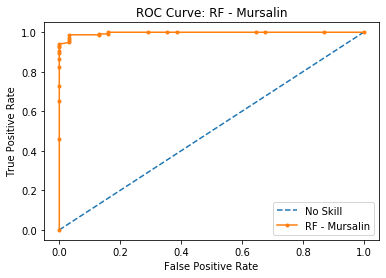

In [272]:
# plot ROC curve
plot_roc_curve(y_test, probabilities=rf_probabilites, model_name="RF - Mursalin")

In [82]:
# fpr, tpr, _ = roc_curve(y_test, rf_pred)
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label = "auc = " + str(roc_auc))
# plt.title("Area Under Curve Plot")
# plt.show()

In [83]:
# plt.figure(figsize=(20,7))
# plt.plot(np.arange(len(rf_pred)), rf_pred, label='pred')
# plt.plot(np.arange(len(y_test)), y_test, label='actual' )
# plt.title('Predicted versus actual labels in the test set')
# plt.legend();

In [84]:
# plt.figure(figsize=(20,7))
# plt.figure(figsize=(20,7))
# plt.plot(np.arange(len(rf_probabilites)), rf_probabilites, label='rf_pred_probability')
# plt.plot(np.arange(len(y_test)), y_test, label='actual' )
# plt.title('Prediction probability versus actual in the test set')
# plt.legend()
# plt.show()

### Discussion


## Paper #2: Wang et al. (2019)

The authors propose an automatic detection framework for epileptic seizure based on multiple time-frequency analysis approaches. Their approach involves a novel random forest(RF) model combined with grid search optimization (GSO). The short-time Fourier transformation visualizes seizure features after normalization. The dimensionality of features is reduced through principal component analysis (PCA) before feeding them into the classification model. The training parameters are optimized using GSO to improve detection performance and diagnostic accuracy by in the recognition of three different levels epileptic of conditions (healthy subjects, seizure-free intervals, seizure activity). 


The proposed model was used to classify 500 samples of raw EEG data, and multiple cross-validations were adopted to boost the modeling accuracy. Experimental results were evaluated by an accuracy, a confusion matrix, a receiver operating characteristic curve, and an area under the curve.


**Dataset and Feature Extraction Methods**

Non-invasive EEG data was obtained at Bonn University from 25 patients with medically intractable partial epilepsy.  The datasets were divided into five groups of ictal scalp EEG signals: O, Z, F, N, and S. Each group of data contained a total of 100 samples from 5 subjects. The raw EEG data was recorded using a standard 10–20 system with a sampling frequency of 173. 61 Hz.

First, the authors preprocess the collected medical cEEG data, then perform time-frequency (T-F) analysis on the simulated and real data. The frequency features of frequency and statistics of the EEG signals are extracted by short time Fourier transform (STFT), and the reduced features are fed into the random forest model. Comparisons of the results of the different approaches revealed that STFT attained the best effects. The study adopts the PCA method to reduce the dimensionality of the cEEG features. 

**Random Forest Algorithm Based Grid Search Optimization**

The authors feed the extracted features into the novel automatic detection model using 10-fold CV to obtain the three classification categories of seizure, light-seizure and non-seizure. Model is based on the Random forest (RF) by Archer and Kimes, 2008. Data distribution was performed on the data set, including test set, training set, and verification set. It was directly divided into the three categories of healthy people, intermittent epilepsy patients, and continuous epilepsy patients, which were labeled by “−1,” “1,” “0.”

In order to improve the classification performance of the random forest algorithm, this paper proposes an improved grid search algorithm to optimize and configure the parameters of the RF model.

***GSO***
First coarse search hyper-parameters: penalty parameter, min_sample_leaf, max_features, n_estimators. step size:10 Second accurate search: reduce step size, st. min (penalty parameter) is the best group of parameters, step size:0.1.

***K-Fold Cross-Validation***
To reduce the influence of the selected training data and test data on the model evaluation, k-fold cross validation was used. 

In [176]:
# hakuna matata
rf_gso_model = RandomForestClassifier(n_estimators=65, random_state=42)

### Grid Search Optimization (GSO)

In [177]:
# grid_param = {
#     'n_estimators': [30, 60, 80],
#     'max_features': ['auto', 'sqrt'],
#     'max_depth': [4,6,8] ,
#     'min_samples_split': [2, 5, 10],
#     'criterion': ['gini', 'entropy'],
#     'bootstrap': [True, False]
# }

grid_param = {
    'n_estimators': [30, 65, 80, 100],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'max_depth' : [5, 10, 20, 100],
}

        
grid_search = GridSearchCV(estimator=rf_gso_model,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=10) 
# remove njobs=-1 to avoid errors with https://github.com/scikit-learn-contrib/skope-rules/issues/18

In [178]:
# this takes a while!! zvaita
grid_search.fit(X_train, y_train.ravel())

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=65, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [179]:
# best_grid = grid_search.best_estimator_
# grid_accuracy = get_performance_metrics(best_grid, X_test, y_test)

In [180]:
grid_search.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'n_estimators': 65}

In [181]:
# train with best params
best_rf_gso_model = RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=2, n_estimators=65, random_state=42)
# best_rf_gso_model.fit(X_train, y_train)

In [182]:
# perform KFold cross validation and record ROC AUC values for each fold
cv = KFold(n_splits=10, random_state=1, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores, gso_cv_scores = [], [], [], []
    
for (train, test), i in zip(cv.split(X_train, y_train.ravel()), range(10)):
    best_rf_gso_model.fit(X_train[train], y_train[train])
    _, _, auc_score_train = compute_roc_auc(best_rf_gso_model, train)
    fpr, tpr, auc_score = compute_roc_auc(best_rf_gso_model, test)
    scores.append([auc_score_train, auc_score])
    gso_cv_scores.append(auc_score)
    fprs.append(fpr)
    tprs.append(tpr)

In [183]:
# Actual class predictions
w_best_prediction = best_rf_gso_model.predict(X_test)

# compute cv accuracies
# best_rf_gso_accuracies = cross_val_score(estimator=best_rf_gso_model, X=X_train, y=y_train, cv=10, scoring='roc_auc')
best_rf_gso_accuracies = np.array(gso_cv_scores)

# performance metrics
w_best_accuracy, w_best_prob = get_performance_metrics(best_rf_gso_model, X_test, y_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, w_best_prediction))

print("\n=== All AUC Scores ===")
print(best_rf_gso_accuracies)

print("\n=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", best_rf_gso_accuracies.mean())

print("\n=== STD AUC Score ===")
print("STD AUC Score - Random Forest: ", best_rf_gso_accuracies.std())

=== Performance Metrics ===
Accuracy: 100.00%.
Precision: 100.00%
Recall: 100.00%
F1-score: 100.00%
ROC score: 100.00%
AUC score: 100.00%

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00       554

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


=== All AUC Scores ===
[1.         1.         1.         1.         1.         0.99853801
 0.99977273 1.         1.         1.        ]

=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9998310738968634

=== STD AUC Score ===
STD AUC Score - Random Forest:  0.00043631438329021487


### Plot results

Confusion matrix, without normalization
[[ 46   0]
 [  0 554]]


Normalized confusion matrix
[[1. 0.]
 [0. 1.]]




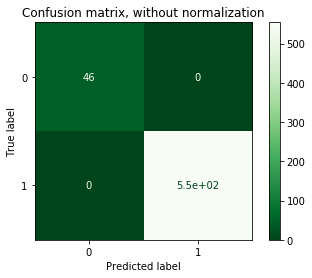

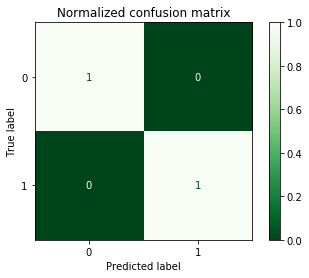

In [184]:
# Plot confusion matrices
plot_confusion(model=best_rf_gso_model, cm=plt.cm.Greens_r)

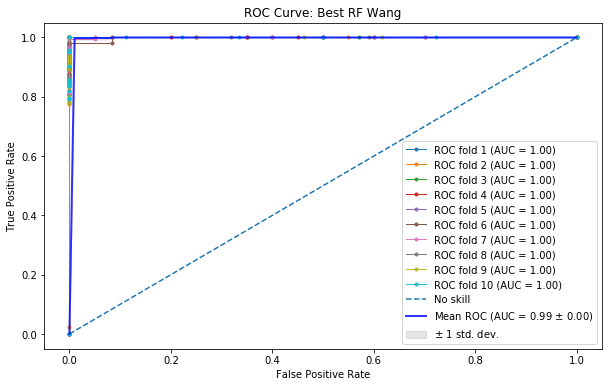

,AUC Train,AUC Test
0,1.0,1.000000
1,1.0,1.000000
2,1.0,1.000000
3,1.0,1.000000
4,1.0,1.000000
5,1.0,0.998538
6,1.0,0.999773
7,1.0,1.000000
8,1.0,1.000000
9,1.0,1.000000


In [185]:
# plot CV roc curve for each fold
plot_cv_roc_curve(fprs, tprs, model_name="Best RF Wang");
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=1.000


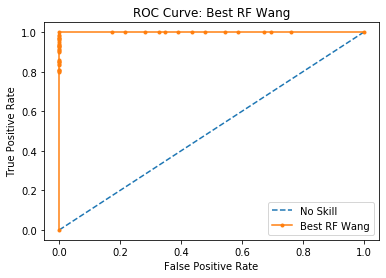

In [186]:
# plot ROC curve
plot_roc_curve(y_test, probabilities=w_best_prob, model_name="Best RF Wang")

In [79]:
# plt.figure(figsize=(20,7))
# plt.plot(np.arange(len(w_best_prediction)), w_best_prediction, label='best_wang_prediction')
# plt.plot(np.arange(len(y_test)), y_test, label='actual' )
# plt.title('Predicted versus actual labels in the test set')
# plt.legend();

In [80]:
# plt.figure(figsize=(20,7))
# plt.figure(figsize=(20,7))
# plt.plot(np.arange(len(w_best_prob)), w_best_prob, label='best_pred_probability')
# plt.plot(np.arange(len(y_test)), y_test, label='actual' )
# plt.title('Prediction probability versus actual in the test set')
# plt.legend()
# plt.show()

### Discussion

## Other Models Considered
* SVM
* ExtraTreesClassifier
* XGBoost
* AdaBoost

### Support Vector Machines (SVM)

In [299]:
# fit the model
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train.ravel())

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [300]:
# Actual class predictions
svm_pred = svm_model.predict(X_test)

# performance metrics
svm_accuracy, svm_prob = get_performance_metrics(svm_model, X_test, y_test)

# compute cv accuracies
svm_accuracies = cross_val_score(estimator=svm_model, X=X_train, y=y_train, cv=10, scoring='roc_auc')

print("\n=== Classification Report ===")
print(classification_report(y_test, svm_pred))

print("\n=== All AUC Scores ===")
print(svm_accuracies)

print("\n=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", svm_accuracies.mean())

print("\n=== STD AUC Score ===")
print("STD AUC Score - Random Forest: ", svm_accuracies.std())

=== Performance Metrics ===
Accuracy: 97.81%.
Precision: 99.59%
Recall: 98.07%
F1-score: 98.82%
ROC score: 98.81%
AUC score: 95.86%

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.94      0.76      0.84        78
           1       0.98      1.00      0.99       970

    accuracy                           0.98      1048
   macro avg       0.96      0.88      0.91      1048
weighted avg       0.98      0.98      0.98      1048


=== All AUC Scores ===
[0.98873801 0.99324281 0.998219   0.99551451 0.96325858 0.98562005
 0.99182058 0.99769129 0.98957784 0.99835092]

=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9902033592895295

=== STD AUC Score ===
STD AUC Score - Random Forest:  0.009880946343890881


### Plot Results: SVM

Confusion matrix, without normalization
[[ 59  19]
 [  4 966]]


Normalized confusion matrix
[[0.75641026 0.24358974]
 [0.00412371 0.99587629]]




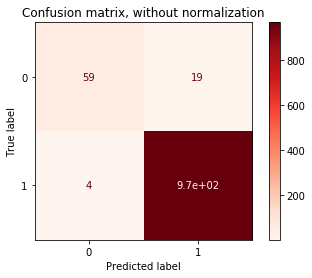

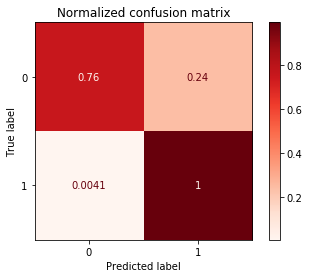

In [301]:
# Plot confusion matrices
plot_confusion(model=svm_model, cm=plt.cm.Reds)

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.988


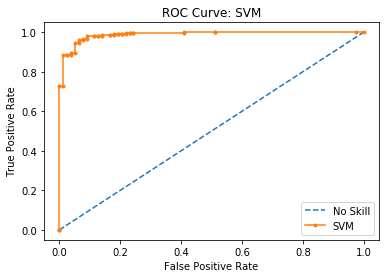

In [302]:
# plot ROC curve
plot_roc_curve(y_test, probabilities=svm_prob, model_name="SVM")

### ExtraTreesClassifier
Improvement to Random Forest

In [303]:
# set best params
n_estimators=65
max_features='auto'

In [304]:
etc_model = ExtraTreesClassifier(n_estimators=n_estimators,
                max_features=max_features)
etc_model.fit(X_train, y_train.ravel())

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [305]:
# Actual class predictions
etc_pred = etc_model.predict(X_test)

# performance metrics
etc_accuracy, etc_prob = get_performance_metrics(etc_model, X_test, y_test)

# compute cv accuracies
etc_accuracies = cross_val_score(estimator=etc_model, X=X_train, y=y_train, cv=10, scoring='roc_auc')

print("\n=== Classification Report ===")
print(classification_report(y_test, etc_pred))

print("\n=== All AUC Scores ===")
print(etc_accuracies)

print("\n=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", etc_accuracies.mean())

print("\n=== STD AUC Score ===")
print("STD AUC Score - Random Forest: ", etc_accuracies.std())

=== Performance Metrics ===
Accuracy: 98.66%.
Precision: 99.59%
Recall: 98.98%
F1-score: 99.28%
ROC score: 99.00%
AUC score: 96.71%

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.94      0.87      0.91        78
           1       0.99      1.00      0.99       970

    accuracy                           0.99      1048
   macro avg       0.97      0.93      0.95      1048
weighted avg       0.99      0.99      0.99      1048


=== All AUC Scores ===
[0.99510908 0.99742583 0.99940633 0.99920844 0.99798813 0.99719657
 0.99544855 1.         0.98453166 0.99897757]

=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9965292168093185

=== STD AUC Score ===
STD AUC Score - Random Forest:  0.004289527630741502


### Plot Results: ExtraTreesClassifier

Confusion matrix, without normalization
[[ 68  10]
 [  4 966]]


Normalized confusion matrix
[[0.87179487 0.12820513]
 [0.00412371 0.99587629]]




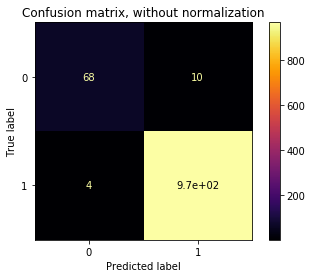

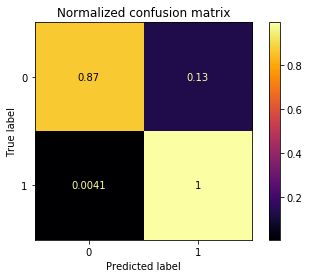

In [306]:
# Plot confusion matrices
plot_confusion(model=etc_model, cm=plt.cm.inferno)

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.990


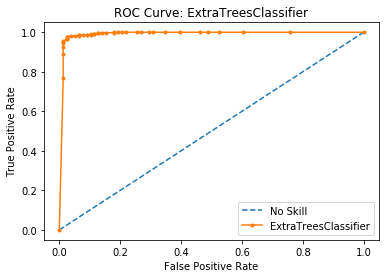

In [307]:
# plot ROC curve
plot_roc_curve(y_test, probabilities=etc_prob, model_name="ExtraTreesClassifier")

### XGBoost Classifier

In [308]:
#!conda install -c anaconda py-xgboost

In [309]:
#! This takes a while!
xgb_model = XGBClassifier()   
xgb_model.fit(X_train, y_train)  

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [310]:
# Actual class predictions
xgb_pred = xgb_model.predict(X_test)

# performance metrics
xgb_accuracy, xgb_prob = get_performance_metrics(xgb_model, X_test, y_test)

# compute cv accuracies
xgb_accuracies = cross_val_score(estimator=xgb_model, X=X_train, y=y_train, cv=10, scoring='roc_auc')

print("\n=== Classification Report ===")
print(classification_report(y_test, xgb_pred))

print("\n=== All AUC Scores ===")
print(xgb_accuracies)

print("\n=== Mean AUC Score ===")
print("Mean AUC Score - XGBClassifier: ", xgb_accuracies.mean())

print("\n=== STD AUC Score ===")
print("STD AUC Score - XGBClassifier: ", xgb_accuracies.std())

=== Performance Metrics ===
Accuracy: 98.95%.
Precision: 99.69%
Recall: 99.18%
F1-score: 99.43%
ROC score: 99.72%
AUC score: 97.53%

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        78
           1       0.99      1.00      0.99       970

    accuracy                           0.99      1048
   macro avg       0.98      0.95      0.96      1048
weighted avg       0.99      0.99      0.99      1048


=== All AUC Scores ===
[0.99504473 0.99781196 0.99927441 0.99914248 0.99155673 0.99960422
 0.99386544 1.         0.98951187 0.99854881]

=== Mean AUC Score ===
Mean AUC Score - XGBClassifier:  0.9964360640967886

=== STD AUC Score ===
STD AUC Score - XGBClassifier:  0.0035323195392677827


In [311]:
# train_score = cross_val_score(xgb_model, X_train, y_train.ravel())
# print("Training score: ",train_score)

# test_score = cross_val_score(xgb_model, X_test, y_test.ravel())
# print("Test score: ", test_score)

# kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(xgb_model, X_train, y_train.ravel(), cv=kfold )
# print("K-fold CV average score:" % kf_cv_scores.mean())

# score2 = xgb_model.score(X_test, y_test.ravel())
# print("Another score: ", score2)

In [312]:
# print(kf_cv_scores.mean())

### Plot Results: XGB

Confusion matrix, without normalization
[[ 70   8]
 [  3 967]]


Normalized confusion matrix
[[0.8974359  0.1025641 ]
 [0.00309278 0.99690722]]




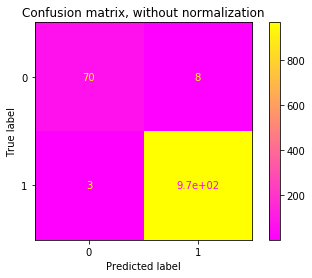

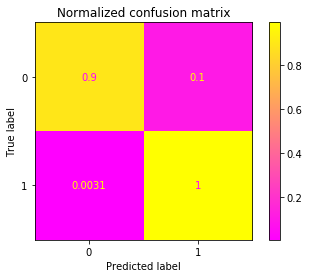

In [313]:
# Plot confusion matrices
plot_confusion(model=xgb_model, cm=plt.cm.spring)

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.997


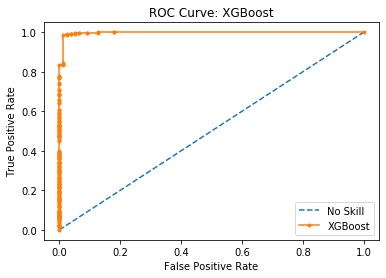

In [314]:
# plot ROC curve
plot_roc_curve(y_test, probabilities=xgb_prob, model_name="XGBoost")

### Adaboost Classifier

In [315]:
ada_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, max_features=10),
                algorithm="SAMME",
                n_estimators=100 )
ada_model.fit(X_train, y_train.ravel())

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=10,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                              

In [316]:
# Actual class predictions
ada_pred = ada_model.predict(X_test)

# performance metrics
ada_accuracy, ada_prob = get_performance_metrics(ada_model, X_test, y_test)

# compute cv accuracies
ada_accuracies = cross_val_score(estimator=ada_model, X=X_train, y=y_train, cv=10, scoring='roc_auc')

print("\n=== Classification Report ===")
print(classification_report(y_test, ada_pred))

print("\n=== All AUC Scores ===")
print(ada_accuracies)

print("\n=== Mean AUC Score ===")
print("Mean AUC Score - AdaBoostClassifier: ", ada_accuracies.mean())

print("\n=== STD AUC Score ===")
print("STD AUC Score - AdaBoostClassifier: ", ada_accuracies.std())

=== Performance Metrics ===
Accuracy: 98.85%.
Precision: 99.79%
Recall: 98.98%
F1-score: 99.38%
ROC score: 99.69%
AUC score: 98.06%

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.87      0.92        78
           1       0.99      1.00      0.99       970

    accuracy                           0.99      1048
   macro avg       0.98      0.93      0.96      1048
weighted avg       0.99      0.99      0.99      1048


=== All AUC Scores ===
[0.98976768 0.99864856 0.99993404 0.9994723  0.99769129 0.99887863
 0.98449868 1.         0.99643799 0.99940633]

=== Mean AUC Score ===
Mean AUC Score - AdaBoostClassifier:  0.9964735504215199

=== STD AUC Score ===
STD AUC Score - AdaBoostClassifier:  0.004923107894334566


### Plot results: ADA

Confusion matrix, without normalization
[[ 68  10]
 [  2 968]]


Normalized confusion matrix
[[0.87179487 0.12820513]
 [0.00206186 0.99793814]]




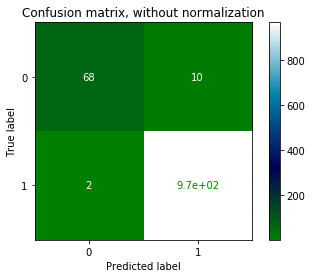

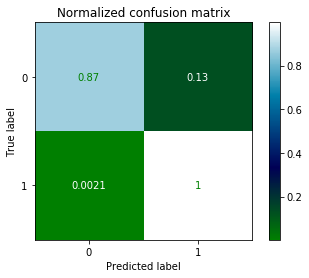

In [317]:
# Plot confusion matrices
plot_confusion(model=ada_model, cm=plt.cm.ocean)

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.997


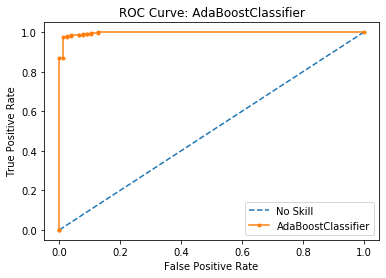

In [318]:
# plot ROC curve
plot_roc_curve(y_test, probabilities=ada_prob, model_name="AdaBoostClassifier")

In [319]:
print("mr dj")

mr dj
